# 1. Setting up the environment

In [67]:
# ==== IMPORT A SETUP ====
import io, zipfile, os, math
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gdown

plt.rcParams["figure.dpi"] = 120
pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 160)

# ==== 1) STAŽENÍ ZIP SOUBORU ZE SDÍLENÉHO LINKU ====
url = "https://drive.google.com/uc?id=1HlOgHnaz1m478Qbi9wBOSSsa-1G-SF_V"
ZIP_PATH = "/content/data.zip"

gdown.download(url, ZIP_PATH, quiet=False)

# ==== 2) FUNKCE PRO "REPORT" ====
def banner(title):
    print("\n" + "="*90)
    print(title.upper())
    print("="*90)

def section(title):
    print("\n" + "-"*90)
    print(title)
    print("-"*90)

def rate_ci(k, n, alpha=0.05):
    if n == 0:
        return (np.nan, np.nan, np.nan)
    p = k / n
    z = 1.96  # ~95% CI
    se = math.sqrt(p*(p)/n)
    return p, p - z*se, p + z*se

# ==== 3) NAČTENÍ ZIPU A CSV SOUBORŮ ====
zf = zipfile.ZipFile(ZIP_PATH)
csv_paths = sorted([p for p in zf.namelist() if p.endswith(".csv")])

def parse_meta(path):
    # path: data/<country>/<league>/<season>.csv
    parts = path.split("/")
    if len(parts) < 4:
        # pokud struktura není přesně data/country/league/season.csv
        return (np.nan, np.nan, np.nan)
    country, league, season = parts[1:4]
    return country, int(league), season.replace(".csv","")

meta = pd.DataFrame([parse_meta(p) for p in csv_paths], columns=["country","league","season"])

# ==== 4) NÁHLED META TABULKY ====
banner("Meta Dataframe")
print(meta.head())


Downloading...
From: https://drive.google.com/uc?id=1HlOgHnaz1m478Qbi9wBOSSsa-1G-SF_V
To: /content/data.zip
100%|██████████| 5.49M/5.49M [00:00<00:00, 189MB/s]


META DATAFRAME
   country  league season
0  belgium       1   1920
1  belgium       1   2021
2  belgium       1   2122
3  belgium       1   2223
4  belgium       1   2324


# 2. Coverage and structure

In [68]:
banner("Data coverage & structure")

print(f"Discovered CSV files: {len(csv_paths)}")



coverage = (meta.value_counts(["country","league"])
                .rename("n_seasons")
                .reset_index()
                .sort_values(["country","league"]))
section("Count of seasons per (country, league)")
display(coverage.head(100))  # can be increased if needed for more view

section("Seasons per country (string listing; no cleaning)")
season_list = meta.groupby("country")["season"].agg(lambda s: ", ".join(sorted(set(s)))).to_frame("seasons")
display(season_list)





DATA COVERAGE & STRUCTURE
Discovered CSV files: 126

------------------------------------------------------------------------------------------
Count of seasons per (country, league)
------------------------------------------------------------------------------------------


,country,league,n_seasons
0,belgium,1,6
1,england,0,6
2,england,1,6
3,england,2,6
4,england,3,6
5,france,1,6
6,france,2,6
7,germany,1,6
8,germany,2,6
9,greece,1,6



------------------------------------------------------------------------------------------
Seasons per country (string listing; no cleaning)
------------------------------------------------------------------------------------------


,seasons
country,
belgium,"1920, 2021, 2122, 2223, 2324, 2425"
england,"1920, 2021, 2122, 2223, 2324, 2425"
france,"1920, 2021, 2122, 2223, 2324, 2425"
germany,"1920, 2021, 2122, 2223, 2324, 2425"
greece,"1920, 2021, 2122, 2223, 2324, 2425"
italy,"1920, 2021, 2122, 2223, 2324, 2425"
netherlands,"1920, 2021, 2122, 2223, 2324, 2425"
portugal,"1920, 2021, 2122, 2223, 2324, 2425"
scotland,"1920, 2021, 2122, 2223, 2324, 2425"


Count of Seasons per Country:

The data has been grouped by country and league, showing how many seasons are available for each country and league combination. For example:

England has data for four different leagues (0, 1, 2, 3), each covering 6 seasons.

Belgium has 6 seasons of data for one league (league 1), and so on for other countries like France, Germany, and Spain.

# 3. Column availability audit (what exists and how often)

In [69]:
banner("Column availability audit")

col_counter = Counter()
for p in csv_paths:
    cols = pd.read_csv(io.BytesIO(zf.read(p)), nrows=0).columns
    col_counter.update(cols)

col_freq = (pd.DataFrame(col_counter.items(), columns=["column","count"])
            .assign(coverage=lambda d: d["count"]/len(csv_paths))
            .sort_values(["coverage","column"], ascending=[False,True]))

section("Highest coverage columns (safe baselines)")
display(col_freq.head(30))

section("Lowest coverage columns (use cautiously)")
display(col_freq.sort_values("coverage").head(20))




COLUMN AVAILABILITY AUDIT

------------------------------------------------------------------------------------------
Highest coverage columns (safe baselines)
------------------------------------------------------------------------------------------


,column,count,coverage
18,AC,126,1.0
16,AF,126,1.0
96,AHCh,126,1.0
55,AHh,126,1.0
22,AR,126,1.0
12,AS,126,1.0
14,AST,126,1.0
20,AY,126,1.0
54,Avg<2.5,126,1.0
53,Avg>2.5,126,1.0



------------------------------------------------------------------------------------------
Lowest coverage columns (use cautiously)
------------------------------------------------------------------------------------------


,column,count,coverage
135,Unnamed: 121,1,0.007937
105,Unnamed: 105,1,0.007937
132,Unnamed: 119,1,0.007937
136,Unnamed: 106,1,0.007937
133,Unnamed: 120,2,0.015873
127,BFECA,21,0.166667
129,BFEC<2.5,21,0.166667
131,BFECAHA,21,0.166667
114,BFEA,21,0.166667
115,BFE>2.5,21,0.166667


Interpretation:
- Columns with coverage ≈ 1.00 are reliable across files (e.g. Div, Date, HomeTeam, AwayTeam, FTHG, FTAG, FTR).
- OU odds columns (e.g. B365>2.5, AvgC>2.5) often have partial coverage; We expect missing values.

# 4. Loading a representative subset

In [70]:
banner("Representative subset and analysis fields")

K = 3  #can be changed more/less seasons per (country, league)

def pick_files(meta_df, k=K):
    out = []
    for (country, league), grp in meta_df.groupby(["country","league"], sort=False):
        for season in sorted(grp["season"].unique(), reverse=True)[:k]:
            p = f"Unprocessed Data/{country}/{league}/{season}.csv"
            if p in csv_paths:
                out.append(p)
    return out

picked_paths = pick_files(meta, K)
print(f"Picked files: {len(picked_paths)}")

maybe_cols = ["Div","Date","Time","HomeTeam","AwayTeam","FTHG","FTAG","FTR",
              "B365>2.5","B365<2.5","AvgC>2.5","AvgC<2.5","MaxC>2.5","MaxC<2.5",
              "HS","AS","HST","AST","HY","AY","HR","AR"]
present_cols = [c for c in maybe_cols if c in dict(col_counter)]

def load_many(paths, usecols=None):
    frames = []
    for p in paths:
        df = pd.read_csv(io.BytesIO(zf.read(p)), usecols=usecols)
        ctry, lg, ssn = parse_meta(p)
        df["country"] = ctry; df["league"] = lg; df["season"] = ssn
        frames.append(df)
    return pd.concat(frames, ignore_index=True)

df = load_many(picked_paths, usecols=present_cols)

# analysis fields (labels only; no cleaning)
df["TotalGoals"] = df["FTHG"] + df["FTAG"]
df["Over_2p5"]   = (df["TotalGoals"] >= 3).astype("Int64")
df["is_draw"]    = (df["FTR"] == "D").astype("Int64")

print(f"Loaded rows: {len(df):,}")
print("Sample rows:")
display(df.head(5))


REPRESENTATIVE SUBSET AND ANALYSIS FIELDS
Picked files: 63
Loaded rows: 21,653
Sample rows:


,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,HY,AY,HR,AR,B365>2.5,B365<2.5,MaxC>2.5,MaxC<2.5,AvgC>2.5,AvgC<2.5,country,league,season,TotalGoals,Over_2p5,is_draw
0,B1,27/07/2024,19:45,Anderlecht,St Truiden,1,0,H,11.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,1.65,2.20,1.63,2.50,1.56,2.40,belgium,1,2425,1,0,0
1,B1,27/07/2024,17:15,Beerschot VA,Oud-Heverlee Leuven,0,0,D,1.0,9.0,0.0,2.0,2.0,1.0,0.0,0.0,1.83,2.03,2.02,1.96,1.92,1.87,belgium,1,2425,0,0,1
2,B1,28/07/2024,17:30,Charleroi,Antwerp,0,1,A,12.0,12.0,5.0,4.0,5.0,2.0,0.0,0.0,1.70,2.10,2.18,1.89,1.98,1.81,belgium,1,2425,1,0,0
3,B1,26/07/2024,19:45,Club Brugge,Mechelen,1,1,D,28.0,5.0,7.0,2.0,1.0,2.0,0.0,0.0,1.60,2.30,1.53,2.75,1.49,2.59,belgium,1,2425,2,0,1
4,B1,27/07/2024,15:00,Dender,St. Gilloise,0,0,D,3.0,10.0,0.0,3.0,4.0,2.0,0.0,0.0,1.53,2.40,1.68,2.43,1.61,2.29,belgium,1,2425,0,0,1


We created subset **TotalGoals**, **Over_2p5**, and **is_draw** for further analysis

# 5. Global scoring profile


GLOBAL SCORING PROFILE
Mean total goals: 2.70
Over 2.5 share:  51.0%  (95% CI ~ 50.3% .. 51.7%)    n=21,653
Draw share:       25.9%  (95% CI ~ 25.6% .. 26.3%)


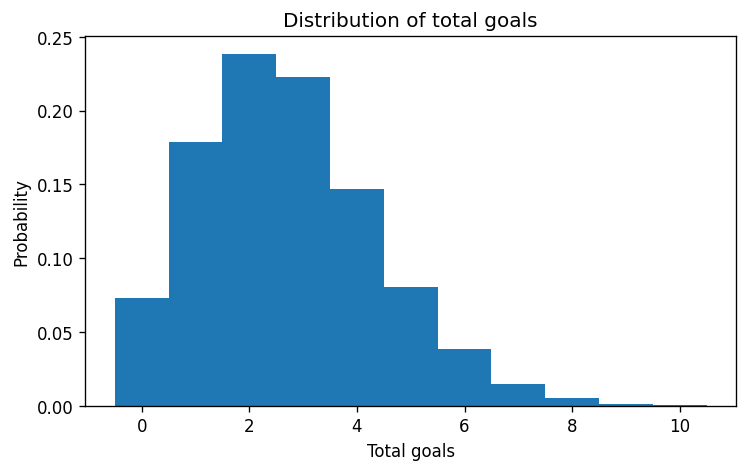

In [71]:
banner("Global scoring profile")

mean_goals = float(df["TotalGoals"].mean())
k_over = int(df["Over_2p5"].sum())
n_all = int(df["Over_2p5"].count())
p_over, lo_over, hi_over = rate_ci(k_over, n_all)

k_draw = int(df["is_draw"].sum())
p_draw, lo_draw, hi_draw = rate_ci(k_draw, n_all)

print(f"Mean total goals: {mean_goals:.2f}")
print(f"Over 2.5 share:  {p_over:.1%}  (95% CI ~ {lo_over:.1%} .. {hi_over:.1%})    n={n_all:,}")
print(f"Draw share:       {p_draw:.1%}  (95% CI ~ {lo_draw:.1%} .. {hi_draw:.1%})")

# Histogram
fig, ax = plt.subplots(figsize=(7,4))
ax.hist(df["TotalGoals"], bins=np.arange(-0.5, 11.5, 1), density=True)
ax.set_title("Distribution of total goals")
ax.set_xlabel("Total goals"); ax.set_ylabel("Probability")
plt.show()


Interpretation:
- If Over 2.5 is ~45–60%, markets are reasonably balanced; naive constant bets would be mediocre.
- This sets a baseline later: any model should beat the majority class to have value.

# 6. Differences by country / league / season


MARKET DIFFERENCES: COUNTRY, LEAGUE, SEASON

------------------------------------------------------------------------------------------
Over 2.5 by country (with 95% CI)
------------------------------------------------------------------------------------------


,k,n,p,lo,hi
country,,,,,
germany,1104,1836,0.601307,0.573802,0.628812
netherlands,546,918,0.594771,0.556296,0.633247
turkey,596,1064,0.56015,0.526492,0.593808
belgium,510,930,0.548387,0.513142,0.583632
scotland,1238,2304,0.537326,0.515386,0.559267
portugal,465,918,0.506536,0.473768,0.539304
france,1037,2056,0.504377,0.482575,0.526180
england,3038,6108,0.49738,0.484907,0.509854
greece,350,713,0.490884,0.454851,0.526916


,k,n,p,lo,hi
country,,,,,
netherlands,546,918,0.594771,0.556296,0.633247
turkey,596,1064,0.56015,0.526492,0.593808
belgium,510,930,0.548387,0.513142,0.583632
scotland,1238,2304,0.537326,0.515386,0.559267
portugal,465,918,0.506536,0.473768,0.539304
france,1037,2056,0.504377,0.482575,0.526180
england,3038,6108,0.49738,0.484907,0.509854
greece,350,713,0.490884,0.454851,0.526916
italy,1057,2280,0.463596,0.444567,0.482626


/tmp/ipython-input-3386482205.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_ylabel("Share"); ax.set_xticklabels(ov_country.index, rotation=45, ha="right")


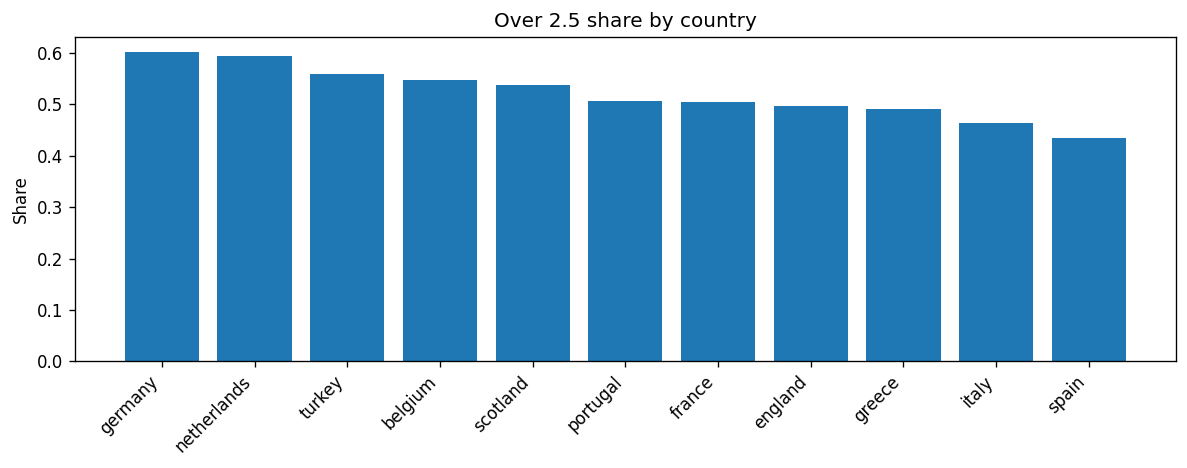

Interpretation:
- Top countries → higher-scoring environments; bottom → tighter games.
- Consider country features or per-country models if the spread is large.

------------------------------------------------------------------------------------------
Over 2.5 by league tier
------------------------------------------------------------------------------------------


,k,n,p,lo,hi
league,,,,,
0,1051,1824,0.576206,0.549762,0.602650
1,5711,10929,0.522555,0.512758,0.532352
2,3223,6704,0.480758,0.469249,0.492266
3,1053,2196,0.479508,0.459453,0.499564


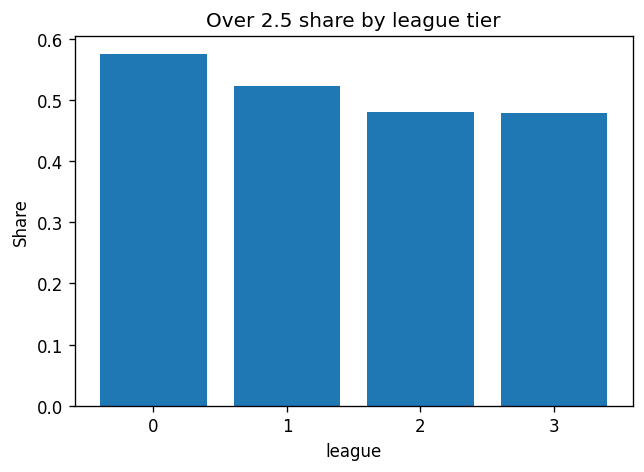

Interpretation:
- If tiers differ meaningfully, include league as a feature or split models per tier.

------------------------------------------------------------------------------------------
Over 2.5 by season (string order)
------------------------------------------------------------------------------------------


,k,n,p,lo,hi
season,,,,,
2223,3573,7277,0.490999,0.479718,0.502280
2324,3851,7247,0.531392,0.519158,0.543627
2425,3614,7129,0.506943,0.495176,0.518711


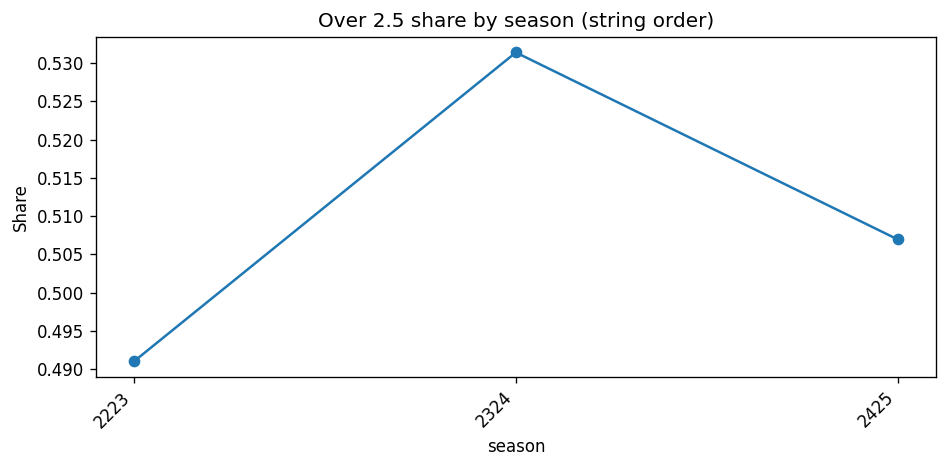

Interpretation:
- Season-to-season drift suggests non-stationarity. Use time-aware splits later (e.g., last season as test).


In [72]:
banner("Market differences: country, league, season")

# Country
section("Over 2.5 by country (with 95% CI)")
ov_country = (df.groupby("country")["Over_2p5"]
                .agg(k="sum", n="count")
                .assign(p=lambda d: d["k"]/d["n"]))
# add CI
cis = ov_country.apply(lambda r: rate_ci(int(r["k"]), int(r["n"])), axis=1, result_type="expand")
cis.columns = ["p","lo","hi"]
ov_country = ov_country.join(cis[["lo","hi"]])
ov_country = ov_country.sort_values("p", ascending=False)
display(ov_country.head(10))
display(ov_country.tail(10))

fig, ax = plt.subplots(figsize=(10,4))
ax.bar(ov_country.index, ov_country["p"].values)
ax.set_title("Over 2.5 share by country")
ax.set_ylabel("Share"); ax.set_xticklabels(ov_country.index, rotation=45, ha="right")
plt.tight_layout(); plt.show()

print("Interpretation:")
print("- Top countries → higher-scoring environments; bottom → tighter games.")
print("- Consider country features or per-country models if the spread is large.")

# League tier
if "league" in df.columns:
    section("Over 2.5 by league tier")
    ov_league = (df.groupby("league")["Over_2p5"]
                   .agg(k="sum", n="count")
                   .assign(p=lambda d: d["k"]/d["n"])
                   .sort_index())
    cis_l = ov_league.apply(lambda r: rate_ci(int(r["k"]), int(r["n"])), axis=1, result_type="expand")
    cis_l.columns = ["p_ci","lo","hi"]
    ov_league = ov_league.drop(columns="p").join(cis_l.rename(columns={"p_ci":"p"}))
    display(ov_league)

    fig, ax = plt.subplots(figsize=(6,4))
    ax.bar(ov_league.index.astype(str), ov_league["p"].values)
    ax.set_title("Over 2.5 share by league tier"); ax.set_xlabel("league"); ax.set_ylabel("Share")
    plt.show()

    print("Interpretation:")
    print("- If tiers differ meaningfully, include league as a feature or split models per tier.")

# Season (string order — true chronology will be handled in cleaning)
section("Over 2.5 by season (string order)")
ov_season = (df.groupby("season")["Over_2p5"]
               .agg(k="sum", n="count")
               .assign(p=lambda d: d["k"]/d["n"])
               .sort_index())
cis_s = ov_season.apply(lambda r: rate_ci(int(r["k"]), int(r["n"])), axis=1, result_type="expand")
cis_s.columns = ["p_ci","lo","hi"]
ov_season = ov_season.drop(columns="p").join(cis_s.rename(columns={"p_ci":"p"}))
display(ov_season)

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(ov_season.index, ov_season["p"].values, marker="o")
ax.set_title("Over 2.5 share by season (string order)"); ax.set_xlabel("season"); ax.set_ylabel("Share")
plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()

print("Interpretation:")
print("- Season-to-season drift suggests non-stationarity. Use time-aware splits later (e.g., last season as test).")


# 7. Home vs away scoring


HOME VS AWAY SCORING


,avg_home_goals,avg_away_goals
country,,
netherlands,1.730937,1.363834
germany,1.714052,1.383987
turkey,1.633459,1.286654
belgium,1.610753,1.258065
scotland,1.537326,1.261285
portugal,1.467320,1.175381
england,1.460544,1.192371
france,1.443580,1.202335
greece,1.408135,1.176718


/tmp/ipython-input-3168566957.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ga.index, rotation=45, ha="right"); ax.legend()


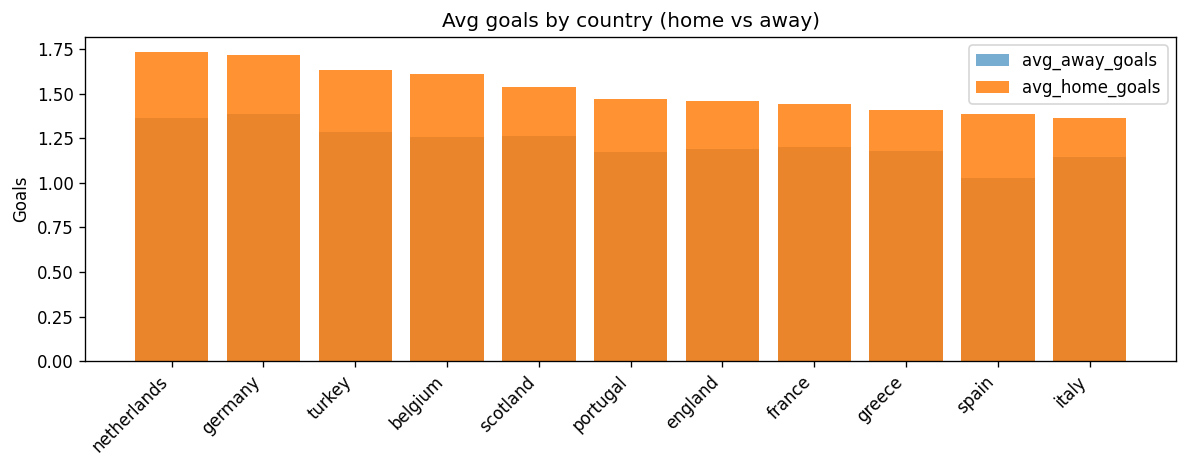

Overall (home − away) goal gap: 0.29

------------------------------------------------------------------------------------------
Top 10 home advantage gaps by country
------------------------------------------------------------------------------------------


/tmp/ipython-input-3168566957.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gap_country = (df.groupby("country").apply(lambda g: (g["FTHG"] - g["FTAG"]).mean())


,home_minus_away
country,
netherlands,0.367102
spain,0.356690
belgium,0.352688
turkey,0.346805
germany,0.330065
portugal,0.291939
scotland,0.276042
england,0.268173
france,0.241245


Interpretation:
- Positive gap indicates home advantage. Consider explicit home/away features and interactions with country/league.


In [73]:
banner("Home vs away scoring")

ga = (df.groupby("country")[["FTHG","FTAG"]]
        .mean()
        .rename(columns={"FTHG":"avg_home_goals","FTAG":"avg_away_goals"})
        .sort_values("avg_home_goals", ascending=False))
display(ga)

m = ga.reset_index().melt(id_vars="country", var_name="side", value_name="avg_goals")
fig, ax = plt.subplots(figsize=(10,4))
for key, grp in m.groupby("side"):
    ax.bar(grp["country"], grp["avg_goals"], alpha=0.85 if key=="avg_home_goals" else 0.6, label=key)
ax.set_title("Avg goals by country (home vs away)"); ax.set_ylabel("Goals")
ax.set_xticklabels(ga.index, rotation=45, ha="right"); ax.legend()
plt.tight_layout(); plt.show()

ha_gap_overall = float((df["FTHG"] - df["FTAG"]).mean())
print(f"Overall (home − away) goal gap: {ha_gap_overall:.2f}")

gap_country = (df.groupby("country").apply(lambda g: (g["FTHG"] - g["FTAG"]).mean())
               .sort_values(ascending=False).rename("home_minus_away"))
section("Top 10 home advantage gaps by country")
display(gap_country.head(10).to_frame())
print("Interpretation:")
print("- Positive gap indicates home advantage. Consider explicit home/away features and interactions with country/league.")


# 8


OU ODDS PRESENCE AND SIMPLE SANITY SIGNAL

------------------------------------------------------------------------------------------
Missing share for AvgC>2.5 by country
------------------------------------------------------------------------------------------


,missing_share
country,
turkey,0.027256
england,0.000000
belgium,0.000000
france,0.000000
germany,0.000000
italy,0.000000
greece,0.000000
netherlands,0.000000
portugal,0.000000


/tmp/ipython-input-2509783668.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_ylabel("Missing share"); ax.set_xticklabels(miss.index, rotation=45, ha="right")


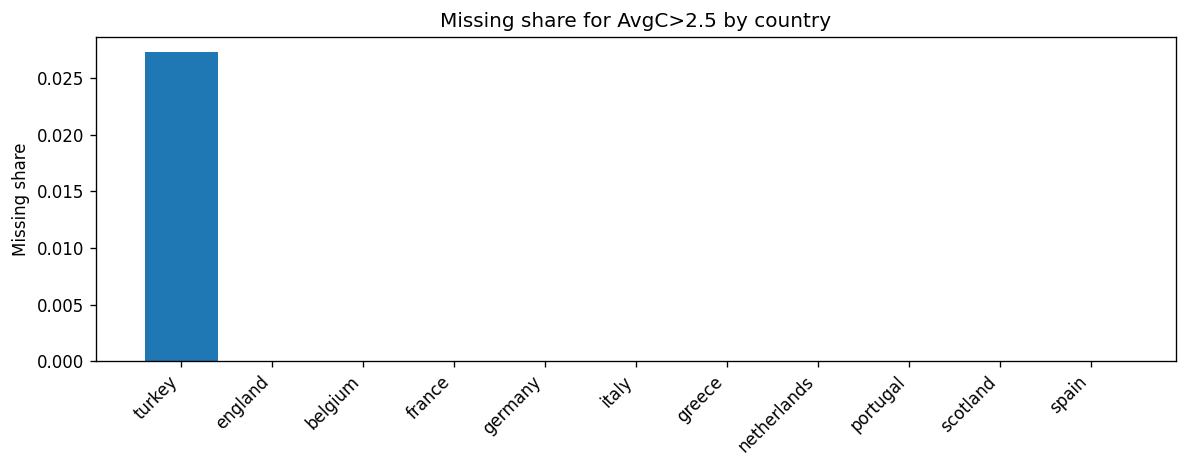

Correlation( implied p from AvgC>2.5, Over_2p5 ) = 0.199

------------------------------------------------------------------------------------------
Implied probability deciles vs Over_2p5 rate
------------------------------------------------------------------------------------------


,decile,over_rate,lift_vs_baseline
0,0,0.35629,-0.152806
1,1,0.411869,-0.097227
2,2,0.431569,-0.077527
3,3,0.467438,-0.041657
4,4,0.483929,-0.025167
5,5,0.519737,0.010641
6,6,0.537718,0.028622
7,7,0.571492,0.062396
8,8,0.615421,0.106325
9,9,0.708333,0.199237


Interpretation:
- Positive correlation and increasing over_rate with higher implied probs indicate odds carry real signal.
- Later, when modeling with odds, use time-aware splits and avoid leakage; where odds are missing, plan a fallback.


In [74]:
banner("OU odds presence and simple sanity signal")

ou_cols = [c for c in ["B365>2.5","B365<2.5","AvgC>2.5","AvgC<2.5","MaxC>2.5","MaxC<2.5"] if c in df.columns]

if ou_cols:
    key_over = next((c for c in ["AvgC>2.5","B365>2.5","MaxC>2.5"] if c in ou_cols), None)
    if key_over:
        section(f"Missing share for {key_over} by country")
        miss = df.groupby("country")[key_over].apply(lambda s: s.isna().mean()).sort_values(ascending=False).to_frame("missing_share")
        display(miss)

        fig, ax = plt.subplots(figsize=(10,4))
        ax.bar(miss.index, miss["missing_share"].values)
        ax.set_title(f"Missing share for {key_over} by country")
        ax.set_ylabel("Missing share"); ax.set_xticklabels(miss.index, rotation=45, ha="right")
        plt.tight_layout(); plt.show()

    # implied probability sanity (decile lift)
    usable = df.dropna(subset=[c for c in ["Over_2p5"] + ou_cols if c in df.columns]).copy()
    if len(usable):
        if "AvgC>2.5" in usable:
            usable["imp_p_over"] = 1.0 / usable["AvgC>2.5"]
            source_col = "AvgC>2.5"
        elif "B365>2.5" in usable:
            usable["imp_p_over"] = 1.0 / usable["B365>2.5"]
            source_col = "B365>2.5"
        else:
            usable["imp_p_over"] = 1.0 / usable["MaxC>2.5"]
            source_col = "MaxC>2.5"

        corr = float(np.corrcoef(usable["imp_p_over"], usable["Over_2p5"].astype(float))[0,1])
        print(f"Correlation( implied p from {source_col}, Over_2p5 ) = {corr:.3f}")

        # Decile lift table
        usable["decile"] = pd.qcut(usable["imp_p_over"], 10, labels=False, duplicates="drop")
        lift = (usable.groupby("decile")["Over_2p5"]
                    .mean()
                    .rename("over_rate")
                    .reset_index()
                    .sort_values("decile"))
        baseline = usable["Over_2p5"].mean()
        lift["lift_vs_baseline"] = lift["over_rate"] - baseline
        section("Implied probability deciles vs Over_2p5 rate")
        display(lift)

        print("Interpretation:")
        print("- Positive correlation and increasing over_rate with higher implied probs indicate odds carry real signal.")
        print("- Later, when modeling with odds, use time-aware splits and avoid leakage; where odds are missing, plan a fallback.")
    else:
        print("Not enough usable rows with OU odds to run sanity checks.")
else:
    print("No OU odds columns present in the loaded subset (they may exist in other seasons/leagues).")


In [75]:
# --- Analyzation of missing values ---
# Function to analyze missing values in data

def missing_values_exploration(df):
    # Get the proportion of NaN values for each column
    missing_share = df.isna().mean().sort_values(ascending=False)

    # Display the columns with the most missing values
    print("\n--- Missing share per column (Descending) ---")
    display(missing_share.head(20))  # Zobraziť prvých 20 stĺpcov

    # Display columns with more than 50% missing values
    print("\n--- Columns with more than 50% missing values ---")
    high_missing_cols = missing_share[missing_share > 0.50]
    display(high_missing_cols)

    # Display columns without any missing values
    print("\n--- Columns without missing values ---")
    no_missing_cols = missing_share[missing_share == 0]
    display(no_missing_cols)

    # Analyze missing values by country (percentage of missing values)
    print("\n--- Missing values by country ---")
    country_missing = df.groupby('country').apply(lambda x: x.isna().mean()).T
    display(country_missing)

    # Analyze missing values by season
    print("\n--- Missing values by season ---")
    season_missing = df.groupby('season').apply(lambda x: x.isna().mean()).T
    display(season_missing)

    # Display the percentage of missing values for the entire datasett
    total_missing = df.isna().mean().mean()   # Average proportion of missing values in the dataset
    print(f"\n--- Total missing values in the dataset: {total_missing:.2%}")


missing_values_exploration(df)

# Count of missing values in columns
missing_count = df.isna().sum().sort_values(ascending=False)
display(missing_count.head(20))  # Zobraziť prvých 20 stĺpcov podľa počtu NaN

# Missing values by league
print("\n--- Missing values by league ---")
league_missing = df.groupby('league').apply(lambda x: x.isna().mean()).T
display(league_missing)

# Missing values by the number of matches in the season
print("\n--- Missing values by season (count of matches) ---")
season_match_count = df.groupby('season').size()
display(season_match_count)



--- Missing share per column (Descending) ---


,0
B365>2.5,0.002309
B365<2.5,0.002309
HS,0.001709
AS,0.001709
HST,0.001709
AST,0.001709
AY,0.001663
HY,0.001663
HR,0.001663
AR,0.001663



--- Columns with more than 50% missing values ---


,0



--- Columns without missing values ---


,0
FTAG,0.0
FTR,0.0
Div,0.0
Date,0.0
Time,0.0
HomeTeam,0.0
AwayTeam,0.0
FTHG,0.0
country,0.0
league,0.0



--- Missing values by country ---


/tmp/ipython-input-2310805234.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  country_missing = df.groupby('country').apply(lambda x: x.isna().mean()).T


country,belgium,england,france,germany,greece,italy,netherlands,portugal,scotland,spain,turkey
Div,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
Date,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
Time,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
HomeTeam,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
AwayTeam,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
FTHG,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
FTAG,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
FTR,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
HS,0.003226,0.000000,0.000000,0.000545,0.001403,0.000000,0.0,0.0,0.000434,0.000000,0.029135
AS,0.003226,0.000000,0.000000,0.000545,0.001403,0.000000,0.0,0.0,0.000434,0.000000,0.029135



--- Missing values by season ---


/tmp/ipython-input-2310805234.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  season_missing = df.groupby('season').apply(lambda x: x.isna().mean()).T


season,2223,2324,2425
Div,0.000000,0.000000,0.000000
Date,0.000000,0.000000,0.000000
Time,0.000000,0.000000,0.000000
HomeTeam,0.000000,0.000000,0.000000
AwayTeam,0.000000,0.000000,0.000000
FTHG,0.000000,0.000000,0.000000
FTAG,0.000000,0.000000,0.000000
FTR,0.000000,0.000000,0.000000
HS,0.004260,0.000276,0.000561
AS,0.004260,0.000276,0.000561



--- Total missing values in the dataset: 0.08%


,0
B365>2.5,50
B365<2.5,50
HS,37
AS,37
HST,37
AST,37
AY,36
HY,36
HR,36
AR,36



--- Missing values by league ---


/tmp/ipython-input-2310805234.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  league_missing = df.groupby('league').apply(lambda x: x.isna().mean()).T


league,0,1,2,3
Div,0.0,0.000000,0.000000,0.000000
Date,0.0,0.000000,0.000000,0.000000
Time,0.0,0.000000,0.000000,0.000000
HomeTeam,0.0,0.000000,0.000000,0.000000
AwayTeam,0.0,0.000000,0.000000,0.000000
FTHG,0.0,0.000000,0.000000,0.000000
FTAG,0.0,0.000000,0.000000,0.000000
FTR,0.0,0.000000,0.000000,0.000000
HS,0.0,0.003294,0.000149,0.000000
AS,0.0,0.003294,0.000149,0.000000



--- Missing values by season (count of matches) ---


,0
season,
2223,7277
2324,7247
2425,7129


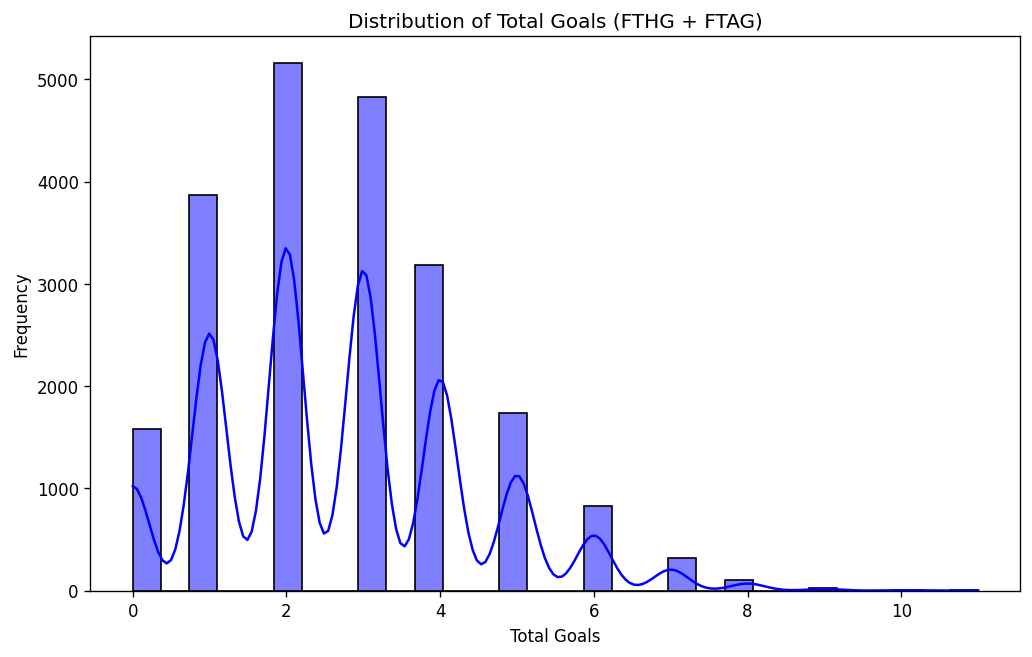

/tmp/ipython-input-3792514304.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Over_2_5', data=df, palette='viridis')


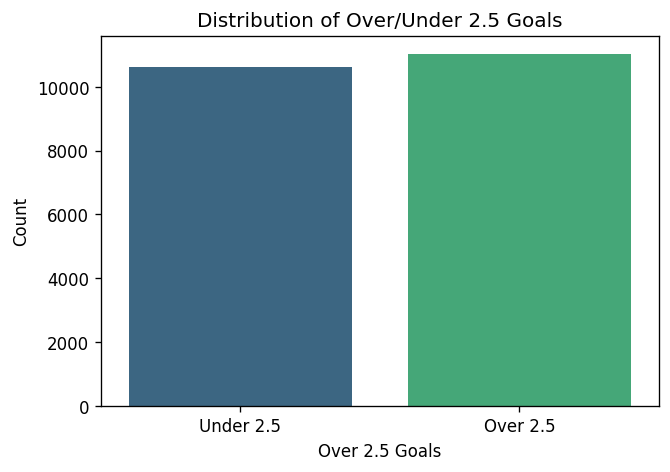

/tmp/ipython-input-3792514304.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_goals_by_country.index, y=avg_goals_by_country.values, palette='viridis')


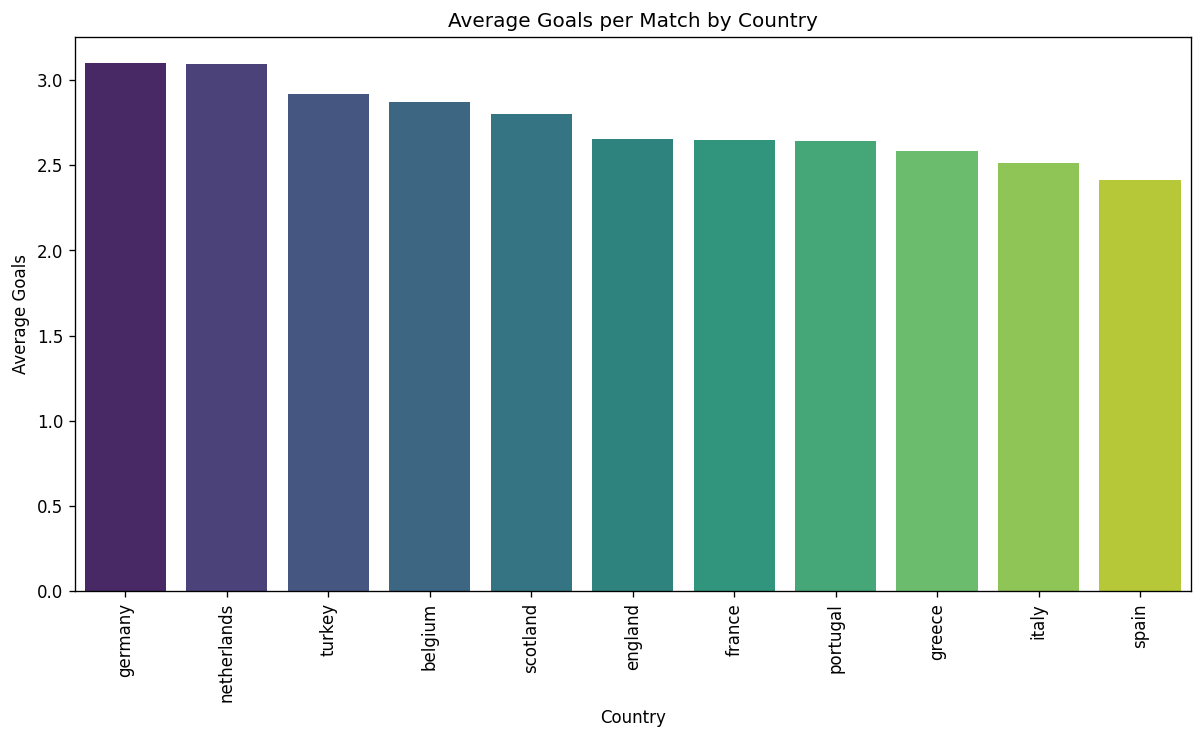

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1) Histogram of Total Goals (FTHG + FTAG)
df['TotalGoals'] = df['FTHG'] + df['FTAG']
plt.figure(figsize=(10, 6))
sns.histplot(df['TotalGoals'], kde=True, bins=30, color='blue')
plt.title('Distribution of Total Goals (FTHG + FTAG)')
plt.xlabel('Total Goals')
plt.ylabel('Frequency')
plt.show()

# 2) Distribution of Over 2.5 Goals (binary classification)
df['Over_2_5'] = (df['TotalGoals'] >= 3).astype(int)
plt.figure(figsize=(6, 4))
sns.countplot(x='Over_2_5', data=df, palette='viridis')
plt.title('Distribution of Over/Under 2.5 Goals')
plt.xlabel('Over 2.5 Goals')
plt.ylabel('Count')
plt.xticks([0, 1], ['Under 2.5', 'Over 2.5'])
plt.show()

# 3) Average Goals by Country
avg_goals_by_country = df.groupby('country')['TotalGoals'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_goals_by_country.index, y=avg_goals_by_country.values, palette='viridis')
plt.title('Average Goals per Match by Country')
plt.xlabel('Country')
plt.ylabel('Average Goals')
plt.xticks(rotation=90)
plt.show()

In [77]:
full_data = pd.DataFrame()

for file_path in csv_paths:

    # Read the CSV file into a DataFrame
    temp_df = pd.read_csv(io.BytesIO(zf.read(file_path)))
    # Extract season from the file name and add it as a new column
    # The first split extracts the filename, the second split removes the file extension
    temp_df["Season"] = file_path.split(os.sep)[-1].split(".")[0]

    # Extract the division name for potential future use
    division = temp_df["Div"].iloc[0]

    full_data = pd.concat([full_data, temp_df], ignore_index=True)

display(full_data.shape)

(42593, 138)

In [78]:
print(full_data.columns.tolist())

['Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA', 'VCH', 'VCD', 'VCA', 'MaxH', 'MaxD', 'MaxA', 'AvgH', 'AvgD', 'AvgA', 'B365>2.5', 'B365<2.5', 'P>2.5', 'P<2.5', 'Max>2.5', 'Max<2.5', 'Avg>2.5', 'Avg<2.5', 'AHh', 'B365AHH', 'B365AHA', 'PAHH', 'PAHA', 'MaxAHH', 'MaxAHA', 'AvgAHH', 'AvgAHA', 'B365CH', 'B365CD', 'B365CA', 'BWCH', 'BWCD', 'BWCA', 'IWCH', 'IWCD', 'IWCA', 'PSCH', 'PSCD', 'PSCA', 'WHCH', 'WHCD', 'WHCA', 'VCCH', 'VCCD', 'VCCA', 'MaxCH', 'MaxCD', 'MaxCA', 'AvgCH', 'AvgCD', 'AvgCA', 'B365C>2.5', 'B365C<2.5', 'PC>2.5', 'PC<2.5', 'MaxC>2.5', 'MaxC<2.5', 'AvgC>2.5', 'AvgC<2.5', 'AHCh', 'B365CAHH', 'B365CAHA', 'PCAHH', 'PCAHA', 'MaxCAHH', 'MaxCAHA', 'AvgCAHH', 'AvgCAHA', 'Season', 'Unnamed: 105', 'BFH', 'BFD', 'BFA', '1XBH', '1XBD', '1XBA', 'BFEH', 'BFED', 'B